In [1]:
import os
import nni
import yaml
import argparse
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from UCTB.dataset import DataSet

from UCTB.dataset import NodeTrafficLoader
from UCTB.model import STMeta
from UCTB.evaluation import metric
from UCTB.preprocess.time_utils import is_work_day_china, is_work_day_america

from UCTB.preprocess.GraphGenerator import GraphGenerator
from UCTB.preprocess import Normalizer, SplitData

Using TensorFlow backend.


In [2]:
inflow_loader = NodeTrafficLoader(dataset="Metro",city="Shanghai_Inflow")

traffic (16416, 287)
test: (1642, 287)
train: (14774, 287)
test: (8362, 287)


In [3]:
outflow_loader = NodeTrafficLoader(dataset="Metro",city="Shanghai_Outflow")

traffic (16416, 287)
test: (1642, 287)
train: (14774, 287)
test: (8362, 287)


In [4]:
inflow_loader.dataset.time_range

['2016-07-01', '2016-09-14']

In [5]:
def showStation(traffic,offset,showdays,stationNum,fitness=5, newfigure=False):
    if newfigure:
        plt.figure(figsize=(20,8))
    offset *= (60//fitness)*24
    offset = int(offset)
    x =traffic[(0+offset):int((60//fitness)*24*showdays+offset),stationNum]
    plt.plot(list(range(len(x))),x)

In [6]:
in_traffic = inflow_loader.traffic_data
out_traffic = outflow_loader.traffic_data

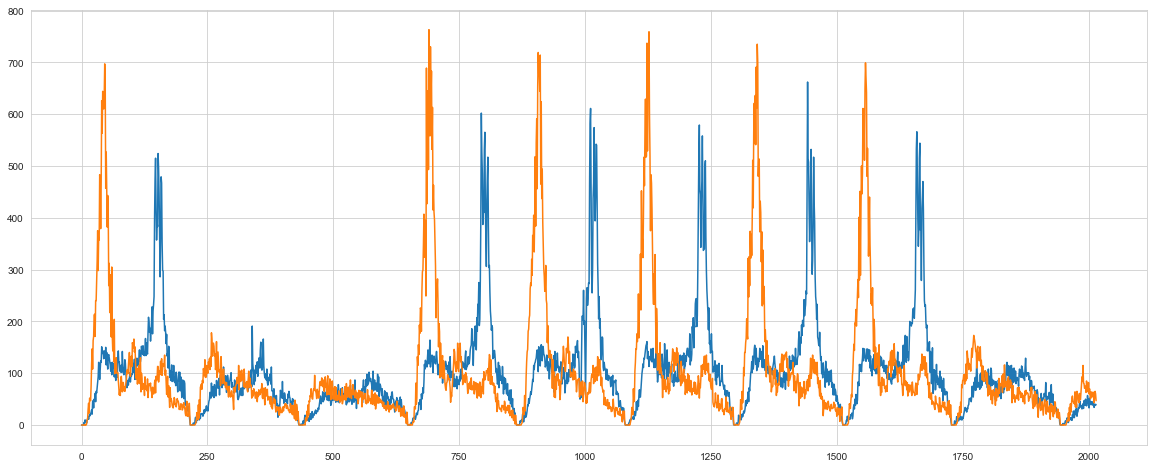

In [7]:
offset = 0
showdays = 7
fitness = 5 # mins
stationNum = 149
plt.figure(figsize=(20,8))
showStation(in_traffic,offset,showdays,stationNum,fitness=fitness)
showStation(out_traffic,offset,showdays,stationNum,fitness=fitness)
# 同一站点的inflow 和outflow展现出明显的pattern

In [8]:
StationInfo = inflow_loader.dataset.data['Node']['StationInfo']

In [9]:
StationInfo

[['0', '0101-0501', 31.111193, 121.385379, '1号线莘庄'],
 ['1', '0102', 31.120899, 121.39302, '1号线外环路'],
 ['2', '0103', 31.130986, 121.402943, '1号线莲花路'],
 ['3', '0104', 31.142217, 121.414107, '1号线锦江乐园'],
 ['4', '0105-0301', 31.154579, 121.430041, '1号线上海南站', '3号线上海南站'],
 ['5', '0106-1225', 31.168338, 121.433141, '1号线漕宝路'],
 ['6', '0107-0426E', 31.182813, 121.437423, '1号线上海体育馆', '4号线上海体育馆'],
 ['7', '0108-0917-1114', 31.195338, 121.436837, '1号线徐家汇', '9号线徐家汇'],
 ['8', '0109', 31.204528, 121.446424, '1号线衡山路'],
 ['9', '0110-0720', 31.213524, 121.449141, '1号线常熟路', '7号线常熟路'],
 ['10', '0111-1017-1219', 31.21515, 121.458744, '10号线陕西南路', '1号线陕西南路'],
 ['11', '0112', 31.222745, 121.473306, '1号线黄陂南路'],
 ['12', '0113-0212-0815', 31.23273, 121.47564, '1号线人民广场', '8号线人民广场'],
 ['13', '0114', 31.238373, 121.468151, '1号线新闸路'],
 ['14', '0115-1217-1312', 31.241883, 121.458699, '1号线汉中路'],
 ['15', '0116-0313-0409', 31.249538, 121.458219, '1号线上海火车站', '3号线上海火车站'],
 ['16', '0117', 31.258891, 121.459204, '1号线中山北路'],
 

In [10]:
station_name_ls = []
for x in StationInfo:
    station_name_ls += x[4:]

In [11]:
import re
pattern = "\d+号线"
lines_names = np.unique([re.match(pattern, x).group() for x in station_name_ls])
lines_names.sort()

In [12]:
lines_names

array(['10号线', '11号线', '12号线', '13号线', '16号线', '1号线', '2号线', '3号线', '4号线',
       '5号线', '6号线', '7号线', '8号线', '9号线'], dtype='<U4')

In [6]:
lat_ls = [x[2] for x in StationInfo]
lng_ls = [x[3] for x in StationInfo]

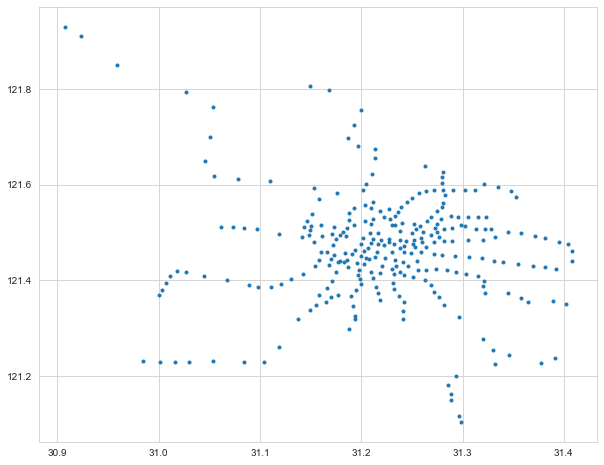

In [11]:
plt.figure(figsize=(10,8))
plt.plot(lat_ls,lng_ls,'.')

In [ ]:
'''
1号地铁时刻表

车站    首班车    常态末班车发车时刻（周日-周四）    延时运营末班车发车时刻（周五-周六）    
往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    
莘庄    05:30    05:30    06:04(到达)    22:32    22:32    23:34(到达)    23:50    23:50    次00:54(到达)    
外环路    05:32    05:32    06:02    22:34    22:34    23:32    23:52    23:52    次00:52    
莲花路    05:34    05:34    06:00    22:36    22:36    23:30    23:54    23:54    次00:50    
锦江乐园    05:37    05:37    05:57    22:39    22:39    23:27    23:57    23:57    次00:47    
上海南站    05:18    04:55    05:54    22:42    22:42    23:24    次00:00    次00:00    次00:44    
漕宝路    05:20    04:57    05:51    22:45    22:45    23:21    次00:03    次00:03    次00:41    
上海体育馆    05:23    05:00    05:49    22:48    22:48    23:19    次00:06    次00:06    次00:39    
徐家汇    05:25    05:02    05:46    22:50    22:50    23:16    次00:08    次00:08    次00:36    
衡山路    05:27    05:04    05:44    22:52    22:52    23:14    次00:10    次00:10    次00:34    
常熟路    05:29    05:06    05:42    22:54    22:54    23:12    次00:12    次00:12    次00:32    
陕西南路    05:31    05:08    05:40    22:56    22:56    23:10    次00:14    次00:14    次00:30    
黄陂南路    05:34    05:11    05:38    22:58    22:58    23:08    次00:16    次00:16    次00:28    
人民广场    05:37    05:14    05:35    23:01    23:01    23:05    次00:19    次00:19    次00:25    
新闸路    05:38    05:15    05:33    23:03    23:03    23:03    次00:21    次00:21    次00:23    
汉中路    05:40    05:17    05:31    23:05    23:05    23:01    次00:23    次00:23    次00:21    
上海火车站    05:43    05:19(到达)    05:30    23:08    23:08    23:00    次00:26    次00:26    次00:20    
中山北路    05:45    --    05:57    23:10    --    22:57    次00:28    --    次00:17    
延长路    05:48    --    05:55    23:13    --    22:55    次00:31    --    次00:15    
上海马戏城    05:50    --    05:53    23:15    --    22:53    次00:33    --    次00:13    
汶水路    05:52    --    05:50    23:17    --    22:50    次00:35    --    次00:10    
彭浦新村    05:55    --    05:47    23:20    --    22:47    次00:38    --    次00:07    
共康路    05:58    --    05:45    23:23    --    22:45    次00:41    --    次00:05    
通河新村    06:00    --    05:42    23:25    --    22:42    次00:43    --    次00:02    
呼兰路    06:03    --    05:40    23:27    --    22:40    次00:45    --    次00:00    
共富新村    06:05    --    05:37    23:30    --    22:37    次00:48    --    23:57    
宝安公路    06:08    --    05:34    23:33    --    22:34    次00:51    --    23:54    
友谊西路    06:10    --    05:32    23:35    --    22:32    次00:53    --    23:52    
富锦路    06:12(到达)    --    05:30    23:37(到达)    --    22:30    次00:55(到达)    --    23:50    

周一　～　周四    
名称    时段    列车间隔    
莘庄～上海火车站    上海火车站～富锦路    
早高峰    7:00～9:00    平均2分30秒    
平峰    9:00～17:00    平均4分    平均6分    
晚高峰    17:00～19:00    平均3分    
其余时段    4分 ～?9分    
周五    
名称    时段    列车间隔    
莘庄～上海火车站    上海火车站～富锦路    
早高峰    7:00～9:00    平均2分30秒    
平峰    9:00～14:30    平均4分    平均6分    
晚高峰    14:30～17:00    平均4分    
17:00～19:00    平均3分    
其余时段    4分～9分    
周六、周日    
名称    时段    列车间隔    
莘庄～上海火车站    上海火车站～富锦路    
高峰时段    9:00～20:00    平均4分    
其余时段    6分～12分    
延时运营列车间隔（周五、周六）    
名称    时段    列车间隔    
莘庄～富锦路    
延时运营    22:30～运营结束    10分～16分    
'''

# crawl

In [56]:
import requests
from pyquery import PyQuery

template = 'http://sh.bendibao.com/ditie/shike_{param}.shtml'
page = 1
url = template.format(param = (page + 222))
resp = requests.get(url = url ,  headers={
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/83.0.4103.97 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;'
              'q=0.9,image/webp,image/apng,*/*;'
              'q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8',
})

In [58]:
pq = PyQuery(resp.text)

In [72]:
item0 = PyQuery(resp.text)
item1 = item0('table tbody tr').items()
for it1 in item1:
    item2 = it1('td').items()
    for it2 in item2:
        string = it2.text()
        print(str(string).replace('\n', '') + '    ',end="")
    print('\n',end="")
print('\n\n',end="")

车站    首班车    常态末班车发车时刻（周日-周四）    延时运营末班车发车时刻（周五-周六）    
往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    
莘庄    05:30    05:30    06:04(到达)    22:32    22:32    23:34(到达)    23:50    23:50    次00:54(到达)    
外环路    05:32    05:32    06:02    22:34    22:34    23:32    23:52    23:52    次00:52    
莲花路    05:34    05:34    06:00    22:36    22:36    23:30    23:54    23:54    次00:50    
锦江乐园    05:37    05:37    05:57    22:39    22:39    23:27    23:57    23:57    次00:47    
上海南站    05:18    04:55    05:54    22:42    22:42    23:24    次00:00    次00:00    次00:44    
漕宝路    05:20    04:57    05:51    22:45    22:45    23:21    次00:03    次00:03    次00:41    
上海体育馆    05:23    05:00    05:49    22:48    22:48    23:19    次00:06    次00:06    次00:39    
徐家汇    05:25    05:02    05:46    22:50    22:50    23:16    次00:08    次00:08    次00:36    
衡山路    05:27    05:04    05:44    22:52    22:52    23:14    次00:10    次00:10    次00:34    
常熟路    05:29    05:06    05:42    22:54

In [ ]:
/html/body/div[5]/div/div[1]/div[3]/table[1]